In [1]:
import os
import json
import pickle
import sys
sys.path.insert(0, '../')
from src.DataSaver import DataSaver
from src.DynamicSystemAnalyzer import DynamicSystemAnalyzer
from src.PerformanceAnalyzer import PerformanceAnalyzer
from src.RNN_numpy import RNN_numpy
from src.utils import get_project_root, numpify, orthonormalize
from src.Trainer import Trainer
from src.RNN_torch import RNN_torch
from src.Task import *
from matplotlib import pyplot as plt
import torch
import time
from sklearn.decomposition import PCA

In [2]:
disp = True
activation = "tanh"
taskname = "MemoryAntiAngle"
train_config_file = f"train_config_{taskname}_{activation}.json"
config_dict = json.load(open(os.path.join(get_project_root(), "data", "configs", train_config_file), mode="r"))

In [3]:
# defining RNN:
N = config_dict["N"]
activation_name = config_dict["activation"]
if activation_name == 'relu':
    activation = lambda x: torch.maximum(x, torch.tensor(0))
elif activation_name == 'tanh':
    activation = torch.tanh
elif activation_name == 'sigmoid':
    activation = lambda x: 1/(1 + torch.exp(-x))
elif activation_name == 'softplus':
    activation = lambda x: torch.log(1 + torch.exp(5 * x))

dt = config_dict["dt"]
tau = config_dict["tau"]
constrained = config_dict["constrained"]
connectivity_density_rec = config_dict["connectivity_density_rec"]
spectral_rad = config_dict["sr"]
sigma_inp = config_dict["sigma_inp"]
sigma_rec = config_dict["sigma_rec"]
seed = config_dict["seed"]
rng = torch.Generator()
if not seed is None:
    rng.manual_seed(seed)
input_size = config_dict["num_inputs"]
output_size = config_dict["num_outputs"]

In [4]:
# Task:
n_steps = config_dict["n_steps"]
task_params = config_dict["task_params"]

In [5]:
# Trainer:
lambda_orth = config_dict["lambda_orth"]
lambda_r = config_dict["lambda_r"]
mask = np.array(config_dict["mask"])
max_iter = config_dict["max_iter"]
tol = config_dict["tol"]
lr = config_dict["lr"]
weight_decay = config_dict["weight_decay"]
same_batch = config_dict["same_batch"]

In [6]:
# General:
tag = config_dict["tag"]
timestr = time.strftime("%Y%m%d-%H%M%S")
data_folder = os.path.join(config_dict["data_folder"], timestr)

In [7]:
# creating instances:
rnn_torch = RNN_torch(N=N, dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                      activation=activation, constrained=constrained,
                      sigma_inp=sigma_inp, sigma_rec=sigma_rec,
                      connectivity_density_rec=connectivity_density_rec,
                      spectral_rad=spectral_rad,
                      random_generator=rng)
task = eval("Task" + taskname)(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn_torch.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)
trainer = Trainer(RNN=rnn_torch, Task=task,
                  max_iter=max_iter, tol=tol,
                  optimizer=optimizer, criterion=criterion,
                  lambda_orth=lambda_orth, lambda_r=lambda_r)
datasaver = None

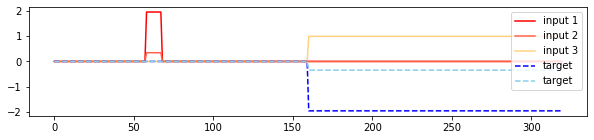

In [8]:
inputs, targets, conditions = task.get_batch()
ind = 11

fig = plt.figure(figsize = (10, 2))
plt.plot(inputs[0, :, ind], color = 'red', label = 'input 1')
plt.plot(inputs[1, :, ind], color = 'tomato', label = 'input 2')
plt.plot(inputs[2, :, ind], color = 'orange', alpha = 0.5, label = 'input 3')
plt.plot(targets[0, :, ind], color = 'blue', linestyle = '--', label = 'target')
plt.plot(targets[1, :, ind], color = 'skyblue', linestyle = '--', label = 'target')
plt.legend()
plt.show()

In [9]:
rnn_trained, train_losses, val_losses, net_params = trainer.run_training(train_mask=mask, same_batch=same_batch)

iteration 0, train loss: 2.429176, validation loss: 2.328537
iteration 1, train loss: 2.335872, validation loss: 2.271955
iteration 2, train loss: 2.279186, validation loss: 2.250031
iteration 3, train loss: 2.252123, validation loss: 2.20759
iteration 4, train loss: 2.211034, validation loss: 2.112191
iteration 5, train loss: 2.127065, validation loss: 1.972309
iteration 6, train loss: 2.099856, validation loss: 1.940001
iteration 7, train loss: 2.066631, validation loss: 1.906772
iteration 8, train loss: 1.983698, validation loss: 1.918153
iteration 9, train loss: 1.972612, validation loss: 1.868651
iteration 10, train loss: 1.901346, validation loss: 1.828792
iteration 11, train loss: 1.882014, validation loss: 1.719321
iteration 12, train loss: 1.800636, validation loss: 1.715057
iteration 13, train loss: 1.755106, validation loss: 1.704498
iteration 14, train loss: 1.719194, validation loss: 1.609042
iteration 15, train loss: 1.655844, validation loss: 1.548146
iteration 16, train

iteration 117, train loss: 0.220167, validation loss: 0.204509
iteration 118, train loss: 0.22841, validation loss: 0.176712
iteration 119, train loss: 0.219786, validation loss: 0.170379
iteration 120, train loss: 0.238613, validation loss: 0.161467
iteration 121, train loss: 0.22253, validation loss: 0.151776
iteration 122, train loss: 0.210257, validation loss: 0.143084
iteration 123, train loss: 0.258397, validation loss: 0.175491
iteration 124, train loss: 0.21053, validation loss: 0.159497
iteration 125, train loss: 0.220298, validation loss: 0.155175
iteration 126, train loss: 0.217508, validation loss: 0.180428
iteration 127, train loss: 0.226843, validation loss: 0.177527
iteration 128, train loss: 0.215533, validation loss: 0.157817
iteration 129, train loss: 0.211637, validation loss: 0.155781
iteration 130, train loss: 0.227479, validation loss: 0.178825
iteration 131, train loss: 0.232283, validation loss: 0.168457
iteration 132, train loss: 0.207099, validation loss: 0.12

iteration 246, train loss: 0.1749, validation loss: 0.156526
iteration 247, train loss: 0.175404, validation loss: 0.119352
iteration 248, train loss: 0.17883, validation loss: 0.131363
iteration 249, train loss: 0.146184, validation loss: 0.116301
iteration 250, train loss: 0.194979, validation loss: 0.147266
iteration 251, train loss: 0.17196, validation loss: 0.149572
iteration 252, train loss: 0.204285, validation loss: 0.136816
iteration 253, train loss: 0.163535, validation loss: 0.139083
iteration 254, train loss: 0.151553, validation loss: 0.163622
iteration 255, train loss: 0.163011, validation loss: 0.137105
iteration 256, train loss: 0.176086, validation loss: 0.153181
iteration 257, train loss: 0.176064, validation loss: 0.134781
iteration 258, train loss: 0.155053, validation loss: 0.128041
iteration 259, train loss: 0.1909, validation loss: 0.138303
iteration 260, train loss: 0.195638, validation loss: 0.135126
iteration 261, train loss: 0.155088, validation loss: 0.13992

iteration 377, train loss: 0.159785, validation loss: 0.122523
iteration 378, train loss: 0.143487, validation loss: 0.120128
iteration 379, train loss: 0.163854, validation loss: 0.106284
iteration 380, train loss: 0.181044, validation loss: 0.146638
iteration 381, train loss: 0.159869, validation loss: 0.152178
iteration 382, train loss: 0.182274, validation loss: 0.12612
iteration 383, train loss: 0.173219, validation loss: 0.13358
iteration 384, train loss: 0.165738, validation loss: 0.140777
iteration 385, train loss: 0.165677, validation loss: 0.129379
iteration 386, train loss: 0.175974, validation loss: 0.161584
iteration 387, train loss: 0.179309, validation loss: 0.14108
iteration 388, train loss: 0.157795, validation loss: 0.153842
iteration 389, train loss: 0.177226, validation loss: 0.151986
iteration 390, train loss: 0.191028, validation loss: 0.123748
iteration 391, train loss: 0.179984, validation loss: 0.124824
iteration 392, train loss: 0.180106, validation loss: 0.12

iteration 507, train loss: 0.161856, validation loss: 0.133943
iteration 508, train loss: 0.163352, validation loss: 0.110898
iteration 509, train loss: 0.169251, validation loss: 0.128714
iteration 510, train loss: 0.172849, validation loss: 0.117418
iteration 511, train loss: 0.198214, validation loss: 0.134
iteration 512, train loss: 0.152246, validation loss: 0.133116
iteration 513, train loss: 0.180099, validation loss: 0.134539
iteration 514, train loss: 0.195753, validation loss: 0.123294
iteration 515, train loss: 0.148076, validation loss: 0.129135
iteration 516, train loss: 0.161195, validation loss: 0.132888
iteration 517, train loss: 0.135212, validation loss: 0.123412
iteration 518, train loss: 0.171095, validation loss: 0.12305
iteration 519, train loss: 0.148899, validation loss: 0.128616
iteration 520, train loss: 0.173003, validation loss: 0.130424
iteration 521, train loss: 0.166948, validation loss: 0.122619
iteration 522, train loss: 0.14449, validation loss: 0.1342

iteration 637, train loss: 0.126907, validation loss: 0.09533
iteration 638, train loss: 0.139812, validation loss: 0.104399
iteration 639, train loss: 0.123552, validation loss: 0.108485
iteration 640, train loss: 0.138432, validation loss: 0.092118
iteration 641, train loss: 0.139347, validation loss: 0.101148
iteration 642, train loss: 0.136045, validation loss: 0.113472
iteration 643, train loss: 0.141272, validation loss: 0.104263
iteration 644, train loss: 0.127382, validation loss: 0.09792
iteration 645, train loss: 0.132635, validation loss: 0.085694
iteration 646, train loss: 0.129667, validation loss: 0.078447
iteration 647, train loss: 0.126576, validation loss: 0.089983
iteration 648, train loss: 0.125254, validation loss: 0.097868
iteration 649, train loss: 0.131467, validation loss: 0.093658
iteration 650, train loss: 0.134904, validation loss: 0.109498
iteration 651, train loss: 0.13415, validation loss: 0.107226
iteration 652, train loss: 0.14064, validation loss: 0.088

iteration 767, train loss: 0.104525, validation loss: 0.075485
iteration 768, train loss: 0.115716, validation loss: 0.072187
iteration 769, train loss: 0.105932, validation loss: 0.083274
iteration 770, train loss: 0.111179, validation loss: 0.064729
iteration 771, train loss: 0.100873, validation loss: 0.065102
iteration 772, train loss: 0.097892, validation loss: 0.062618
iteration 773, train loss: 0.107604, validation loss: 0.073385
iteration 774, train loss: 0.100004, validation loss: 0.065628
iteration 775, train loss: 0.108847, validation loss: 0.075543
iteration 776, train loss: 0.09922, validation loss: 0.06295
iteration 777, train loss: 0.108298, validation loss: 0.071268
iteration 778, train loss: 0.105146, validation loss: 0.072127
iteration 779, train loss: 0.101173, validation loss: 0.081279
iteration 780, train loss: 0.119023, validation loss: 0.079248
iteration 781, train loss: 0.088966, validation loss: 0.072184
iteration 782, train loss: 0.097216, validation loss: 0.0

iteration 897, train loss: 0.09971, validation loss: 0.067862
iteration 898, train loss: 0.099913, validation loss: 0.063679
iteration 899, train loss: 0.096093, validation loss: 0.070126
iteration 900, train loss: 0.102031, validation loss: 0.060769
iteration 901, train loss: 0.095634, validation loss: 0.083478
iteration 902, train loss: 0.103169, validation loss: 0.077798
iteration 903, train loss: 0.092779, validation loss: 0.062079
iteration 904, train loss: 0.095916, validation loss: 0.05431
iteration 905, train loss: 0.093868, validation loss: 0.060583
iteration 906, train loss: 0.092456, validation loss: 0.078067
iteration 907, train loss: 0.108481, validation loss: 0.057389
iteration 908, train loss: 0.091925, validation loss: 0.074892
iteration 909, train loss: 0.105144, validation loss: 0.063866
iteration 910, train loss: 0.090949, validation loss: 0.067693
iteration 911, train loss: 0.096687, validation loss: 0.090593
iteration 912, train loss: 0.114394, validation loss: 0.0

iteration 1024, train loss: 0.064859, validation loss: 0.039031
iteration 1025, train loss: 0.06435, validation loss: 0.039554
iteration 1026, train loss: 0.07246, validation loss: 0.041644
iteration 1027, train loss: 0.065618, validation loss: 0.03843
iteration 1028, train loss: 0.06281, validation loss: 0.040566
iteration 1029, train loss: 0.068112, validation loss: 0.037767
iteration 1030, train loss: 0.06621, validation loss: 0.043064
iteration 1031, train loss: 0.06867, validation loss: 0.035679
iteration 1032, train loss: 0.062056, validation loss: 0.036859
iteration 1033, train loss: 0.073156, validation loss: 0.045749
iteration 1034, train loss: 0.07655, validation loss: 0.05822
iteration 1035, train loss: 0.082526, validation loss: 0.038887
iteration 1036, train loss: 0.067322, validation loss: 0.049802
iteration 1037, train loss: 0.077294, validation loss: 0.037179
iteration 1038, train loss: 0.070485, validation loss: 0.044956
iteration 1039, train loss: 0.069671, validation

iteration 1150, train loss: 0.05802, validation loss: 0.034878
iteration 1151, train loss: 0.055357, validation loss: 0.029781
iteration 1152, train loss: 0.055485, validation loss: 0.033036
iteration 1153, train loss: 0.057351, validation loss: 0.029633
iteration 1154, train loss: 0.053448, validation loss: 0.032848
iteration 1155, train loss: 0.057511, validation loss: 0.031264
iteration 1156, train loss: 0.059591, validation loss: 0.030452
iteration 1157, train loss: 0.055128, validation loss: 0.030032
iteration 1158, train loss: 0.057422, validation loss: 0.029651
iteration 1159, train loss: 0.055935, validation loss: 0.030977
iteration 1160, train loss: 0.05963, validation loss: 0.028553
iteration 1161, train loss: 0.053691, validation loss: 0.029238
iteration 1162, train loss: 0.055791, validation loss: 0.027445
iteration 1163, train loss: 0.055099, validation loss: 0.034241
iteration 1164, train loss: 0.056388, validation loss: 0.029312
iteration 1165, train loss: 0.054682, vali

iteration 1277, train loss: 0.047389, validation loss: 0.02914
iteration 1278, train loss: 0.051979, validation loss: 0.029802
iteration 1279, train loss: 0.0552, validation loss: 0.024724
iteration 1280, train loss: 0.049936, validation loss: 0.027036
iteration 1281, train loss: 0.049255, validation loss: 0.02833
iteration 1282, train loss: 0.049186, validation loss: 0.027968
iteration 1283, train loss: 0.048434, validation loss: 0.029112
iteration 1284, train loss: 0.051072, validation loss: 0.027648
iteration 1285, train loss: 0.051142, validation loss: 0.027235
iteration 1286, train loss: 0.04934, validation loss: 0.025905
iteration 1287, train loss: 0.049337, validation loss: 0.026181
iteration 1288, train loss: 0.052734, validation loss: 0.027781
iteration 1289, train loss: 0.051393, validation loss: 0.026564
iteration 1290, train loss: 0.050337, validation loss: 0.027441
iteration 1291, train loss: 0.051629, validation loss: 0.026645
iteration 1292, train loss: 0.0494, validatio

iteration 1405, train loss: 0.05317, validation loss: 0.024725
iteration 1406, train loss: 0.044445, validation loss: 0.029045
iteration 1407, train loss: 0.04794, validation loss: 0.024008
iteration 1408, train loss: 0.046455, validation loss: 0.023345
iteration 1409, train loss: 0.046167, validation loss: 0.026879
iteration 1410, train loss: 0.047868, validation loss: 0.024305
iteration 1411, train loss: 0.043892, validation loss: 0.023687
iteration 1412, train loss: 0.046127, validation loss: 0.023506
iteration 1413, train loss: 0.046686, validation loss: 0.027154
iteration 1414, train loss: 0.049937, validation loss: 0.026727
iteration 1415, train loss: 0.049986, validation loss: 0.024719
iteration 1416, train loss: 0.04549, validation loss: 0.027339
iteration 1417, train loss: 0.04572, validation loss: 0.026
iteration 1418, train loss: 0.046651, validation loss: 0.025598
iteration 1419, train loss: 0.047775, validation loss: 0.024768
iteration 1420, train loss: 0.047877, validatio

iteration 1533, train loss: 0.044341, validation loss: 0.024159
iteration 1534, train loss: 0.043712, validation loss: 0.024801
iteration 1535, train loss: 0.044387, validation loss: 0.024605
iteration 1536, train loss: 0.046479, validation loss: 0.025182
iteration 1537, train loss: 0.045419, validation loss: 0.025529
iteration 1538, train loss: 0.043825, validation loss: 0.024005
iteration 1539, train loss: 0.044195, validation loss: 0.022943
iteration 1540, train loss: 0.043159, validation loss: 0.022638
iteration 1541, train loss: 0.04414, validation loss: 0.022487
iteration 1542, train loss: 0.046392, validation loss: 0.028235
iteration 1543, train loss: 0.044084, validation loss: 0.02274
iteration 1544, train loss: 0.043258, validation loss: 0.025528
iteration 1545, train loss: 0.047419, validation loss: 0.022586
iteration 1546, train loss: 0.043913, validation loss: 0.025055
iteration 1547, train loss: 0.044732, validation loss: 0.02286
iteration 1548, train loss: 0.044421, valid

iteration 1661, train loss: 0.040654, validation loss: 0.023895
iteration 1662, train loss: 0.043633, validation loss: 0.022252
iteration 1663, train loss: 0.04156, validation loss: 0.022346
iteration 1664, train loss: 0.041913, validation loss: 0.026036
iteration 1665, train loss: 0.044292, validation loss: 0.022827
iteration 1666, train loss: 0.042203, validation loss: 0.028299
iteration 1667, train loss: 0.04712, validation loss: 0.025051
iteration 1668, train loss: 0.045781, validation loss: 0.020942
iteration 1669, train loss: 0.039597, validation loss: 0.024
iteration 1670, train loss: 0.044348, validation loss: 0.023276
iteration 1671, train loss: 0.044021, validation loss: 0.022355
iteration 1672, train loss: 0.043146, validation loss: 0.023016
iteration 1673, train loss: 0.041322, validation loss: 0.021449
iteration 1674, train loss: 0.041043, validation loss: 0.024463
iteration 1675, train loss: 0.047604, validation loss: 0.027774
iteration 1676, train loss: 0.047128, validat

iteration 1790, train loss: 0.048593, validation loss: 0.025606
iteration 1791, train loss: 0.046777, validation loss: 0.024373
iteration 1792, train loss: 0.048293, validation loss: 0.02638
iteration 1793, train loss: 0.044463, validation loss: 0.027127
iteration 1794, train loss: 0.043693, validation loss: 0.023214
iteration 1795, train loss: 0.044086, validation loss: 0.026314
iteration 1796, train loss: 0.045842, validation loss: 0.028114
iteration 1797, train loss: 0.047476, validation loss: 0.022307
iteration 1798, train loss: 0.040303, validation loss: 0.026522
iteration 1799, train loss: 0.044161, validation loss: 0.024588


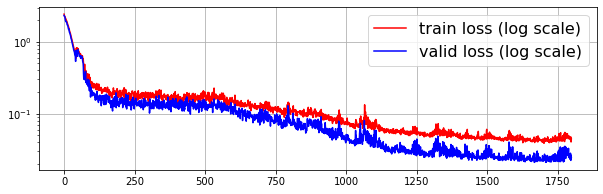

In [10]:
fig_trainloss = plt.figure(figsize=(10, 3))
plt.plot(train_losses, color='r', label='train loss (log scale)')
plt.plot(val_losses, color='b', label='valid loss (log scale)')
plt.yscale("log")
plt.grid(True)
plt.legend(fontsize=16)
if disp:
    plt.show()
if not (datasaver is None): datasaver.save_figure(fig_trainloss, "train&valid_loss")

In [11]:
# validate
RNN_valid = RNN_numpy(N=net_params["N"],
                      dt=net_params["dt"],
                      tau=net_params["tau"],
                      activation=numpify(activation),
                      W_inp=net_params["W_inp"],
                      W_rec=net_params["W_rec"],
                      W_out=net_params["W_out"],
                      bias_rec=net_params["bias_rec"],
                      y_init=net_params["y_init"])

In [12]:
analyzer = PerformanceAnalyzer(RNN_valid)
score_function = lambda x, y: np.mean((x - y) ** 2)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid,
                                      mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)

In [13]:
print(f"MSE validation: {np.round(score, 5)}")
if not (datasaver is None): datasaver.save_data(config_dict, "config.json")
if not (datasaver is None): datasaver.save_data(best_net_params, f"params_{taskname}_{np.round(score, 5)}.pkl")

MSE validation: 0.02268


Plotting random trials


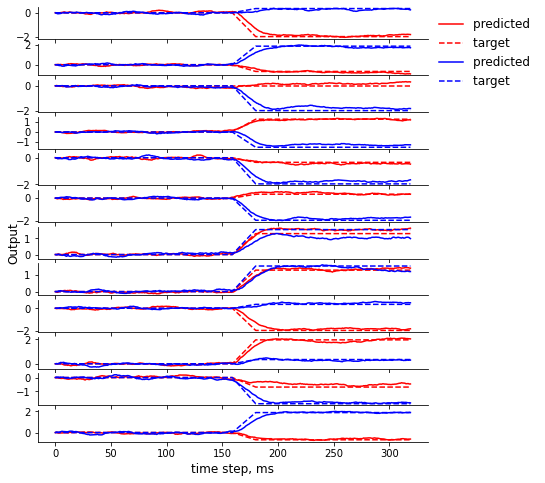

In [14]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]

fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)
if disp:
    plt.show()
if not (datasaver is None): datasaver.save_figure(fig_trials, "random_trials")

In [15]:
dsa = DynamicSystemAnalyzer(RNN_valid)
params = {"fun_tol" : 0.05,
          "diff_cutoff":1e-4,
          "sigma_init_guess":15,
          "patience":100,
          "stop_length":100,
          "mode":"approx"}
dsa.get_fixed_points(Input=np.array([0, 0, 0]), **params)
dsa.get_fixed_points(Input=np.array([0, 0, 1]), **params)

In [16]:
all_points = np.vstack([dsa.fp_data[str([0, 0, 0])][type] for type in list(dsa.fp_data[str([0, 0, 0])].keys())])
pca = PCA(n_components=2)
pca.fit(all_points)
P = np.zeros((RNN_valid.N, 3))
P[:, 0] = RNN_valid.W_out[0, :]
P[:, 1:] = pca.components_.T
P = orthonormalize(P)

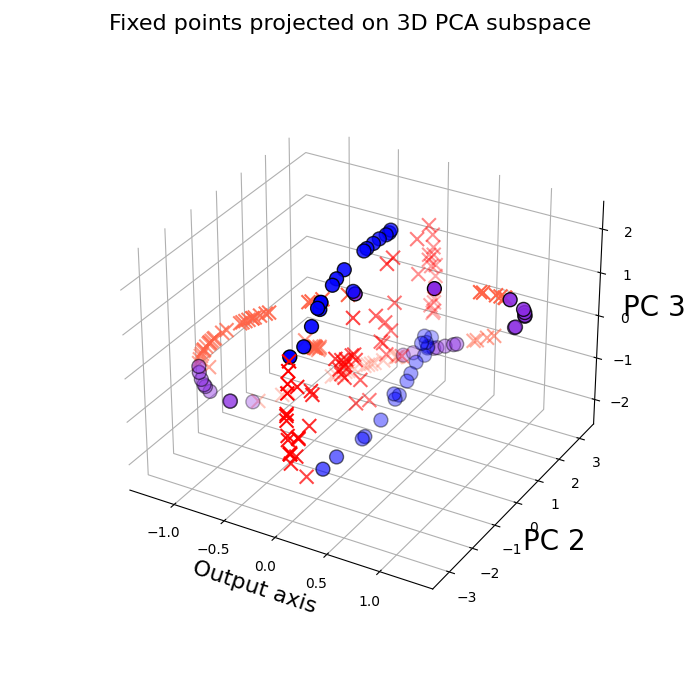

In [17]:
%matplotlib widget

fig_fp = dsa.plot_fixed_points(projection='3D', P=P)
plt.xlabel("Output axis", fontsize=16)
# plt.ylabel("Line", fontsize=16)
if disp:
    plt.show()